In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from src.dataset import *
from src.concept_vectors import *
from src.util import *
from src.plots import *
from src.hierarchy import *
from src.metrics import *
from src.models import * 
from src.create_vectors import *
from sklearn.neighbors import KNeighborsClassifier

2023-03-29 09:49:50.862606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset and Hierarchy Setup

In [5]:
dataset=  MNIST_Dataset()
attributes = dataset.get_attributes()
label_hierarchy = create_hierarchy(create_ward_hierarchy, load_label_vectors_simple,dataset,'',attributes,43)
np.save(open("results/hierarchies/label_mnist.npy","wb"),label_hierarchy.to_array(attributes))
print(attributes)

['0_color', '0_number', '1_color', '1_number', '2_color', '2_number', '3_color', '3_number', '4_color', '4_number', '5_color', '5_number', '6_color', '6_number', '7_color', '7_number', '8_color', '8_number', '9_color', '9_number', 'spurious']


In [6]:
dataset = CUB_Dataset()

In [7]:
attributes = dataset.get_attributes()

In [8]:
shapley_hierarchy = create_hierarchy(create_ward_hierarchy, load_shapley_vectors_simple,dataset,'',attributes,43)
np.save(open("results/hierarchies/shapley_cub.npy","wb"),shapley_hierarchy.to_array(attributes))

In [9]:
label_hierarchy = create_hierarchy(create_ward_hierarchy, load_label_vectors_simple,dataset,'',attributes,43)
np.save(open("results/hierarchies/label_cub.npy","wb"),label_hierarchy.to_array(attributes))

In [8]:
print(shapley_hierarchy)

                          ---- has_upper_tail_color::buff
                     ----|
                          ---- has_under_tail_color::buff

                ----|
                               ---- has_upperparts_color::buff
                          ----|
                                    ---- has_wing_color::buff
                               ----|
                                    ---- has_back_color::buff


                     ----|
                               ---- has_nape_color::buff
                          ----|
                               ---- has_primary_color::buff



           ----|
                     ---- has_throat_color::buff
                ----|
                          ---- has_breast_color::buff
                     ----|
                               ---- has_underparts_color::buff
                          ----|
                               ---- has_belly_color::buff




      ----|
                     ---- has_belly_color::brown
          

In [9]:
print(label_hierarchy)

                     ---- has_throat_color::white
                ----|
                          ---- has_breast_color::white
                     ----|
                               ---- has_underparts_color::white
                          ----|
                               ---- has_belly_color::white



           ----|
                               ---- has_upper_tail_color::grey
                          ----|
                               ---- has_under_tail_color::grey

                     ----|
                               ---- has_wing_color::grey
                          ----|
                                    ---- has_primary_color::grey
                               ----|
                                         ---- has_upperparts_color::grey
                                    ----|
                                         ---- has_back_color::grey




                ----|
                          ---- has_bill_length::about_the_same_as_head
               

## Similar Examples

In [28]:
def find_similar_examples(all_concepts,current_concept,dist_metric):    
    distances = cdist(np.atleast_2d(current_concept), all_concepts, metric=dist_metric)
    indices = np.argsort(distances.squeeze())[:5]
    
    return indices

In [47]:
def plot_closest_images(all_concepts,current_concept,concept_idx,dataset,dist_metric):
    class_names = dataset.class_names
    
    close_examples = find_similar_examples(all_concepts,current_concept,dist_metric)
    current_img_path = dataset.get_data(train=False)[concept_idx]['img_path']
    current_y_val = dataset.get_data(train=False)[concept_idx]['class_label']
        
    train_data = dataset.get_data()
        
    plt.title("Reference image: {}".format(class_names[current_y_val]))
    plot_image('dataset/' + current_img_path)
    
    for i in close_examples:
        plt.title("Comparison image: {}".format(class_names[train_data[i]['class_label']]))
        plot_image('dataset/'+train_data[i]['img_path'])
    

In [48]:
train_logits = np.load("results/logits/train_c.npy") 
train_y = np.load("results/logits/train_y.npy")
valid_logits = np.load("results/logits/valid_c.npy")
valid_y = np.load("results/logits/valid_y.npy")

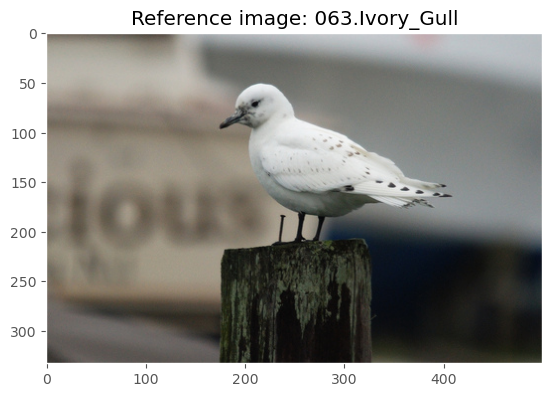

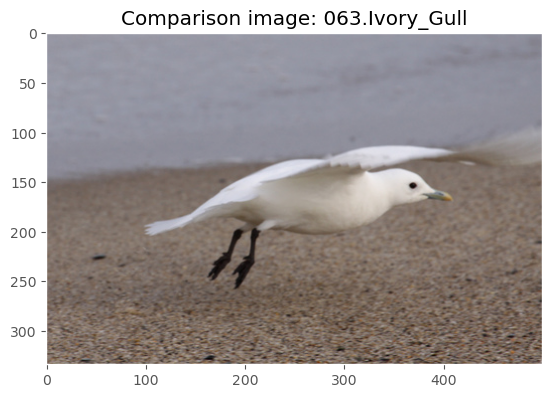

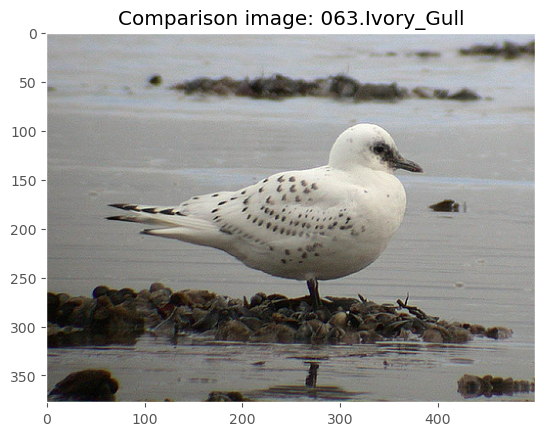

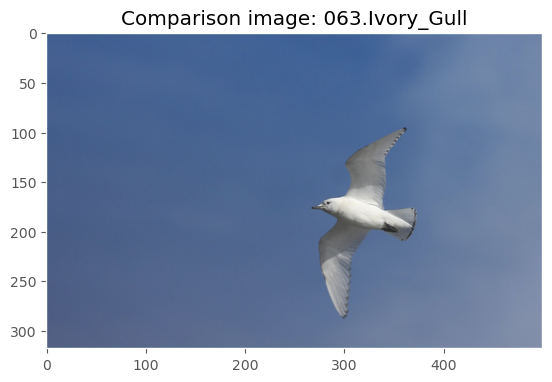

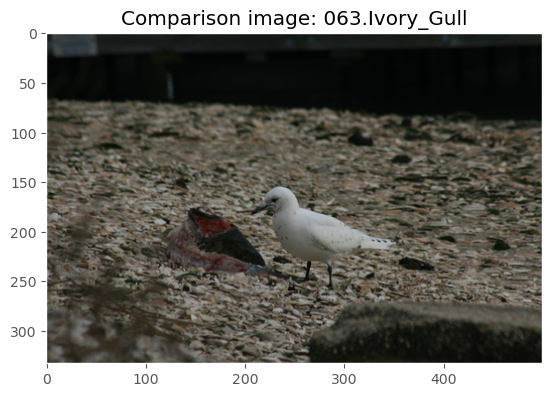

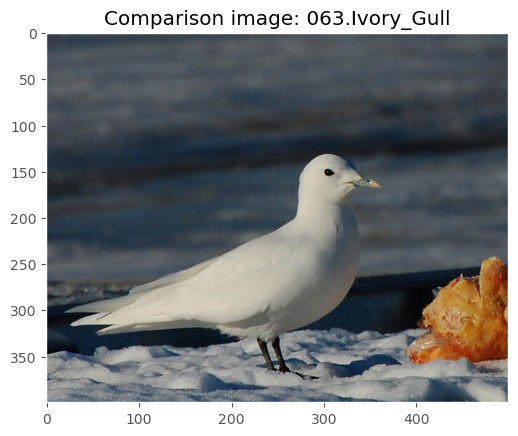

In [49]:
plot_closest_images(train_logits,valid_logits[0],0,dataset,'euclidean')

## Training a KNN from this

In [33]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_logits, train_y)

KNeighborsClassifier()

In [36]:
sum(knn.predict(valid_logits) == valid_y)/len(valid_y)

0.9023372287145242

## Incorporate Hierarchies in

In [51]:
def traverse_hierarchy(hierarchy):
    all_groups = []
    if hierarchy.left_split.leaf or hierarchy.right_split.leaf:
        all_groups.append(hierarchy.value)
    else:
        all_groups += traverse_hierarchy(hierarchy.left_split)
        all_groups += traverse_hierarchy(hierarchy.right_split)
    
    return all_groups 

In [98]:
def groups_to_indices(groups):
    indices = [[dataset.get_attributes().index(j) for j in i] for i in groups]
    num_attributes = sum([len(i) for i in indices])
    
    ret = [1 for i in range(num_attributes)]
    
    for i in indices:
        for j in i:
            ret[j] = 1/len(i)
            
    return np.array(ret)

In [100]:
def dist(x, y, indices):
    diff = np.abs(x-y)*indices
    return np.mean(diff)

In [92]:
groups_shapley = traverse_hierarchy(shapley_hierarchy.root_split)
groups_label = traverse_hierarchy(label_hierarchy.root_split)

In [99]:
indices_shapley = groups_to_indices(groups_shapley)
indices_label = groups_to_indices(groups_label)

In [56]:
example_idx = np.argmin(knn.predict(valid_logits) == valid_y)
example_idx

2

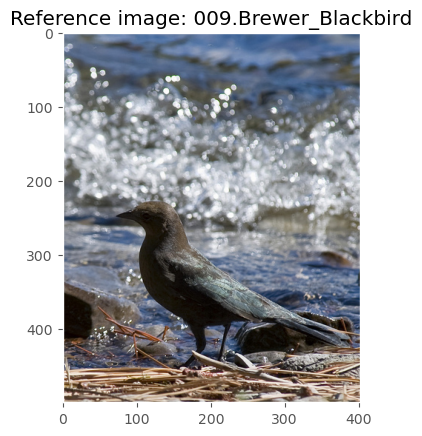

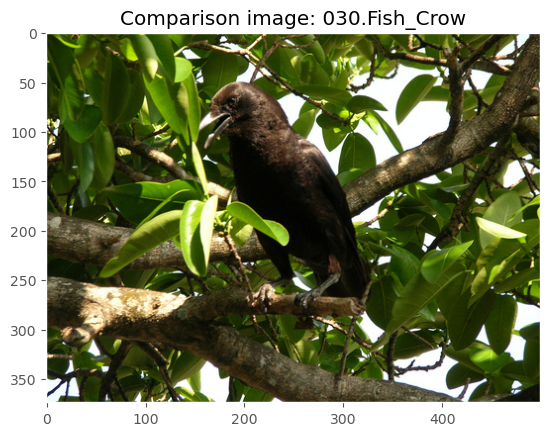

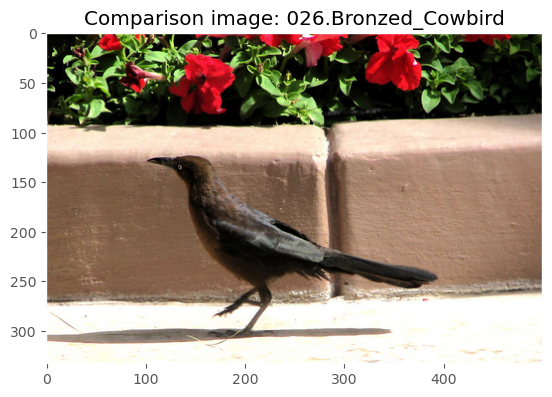

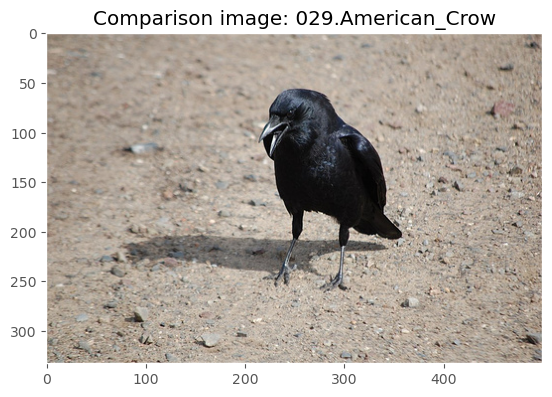

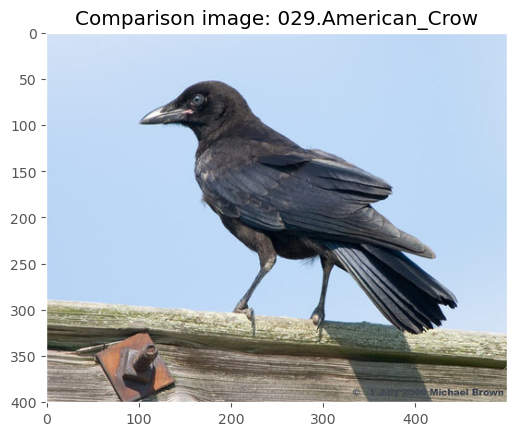

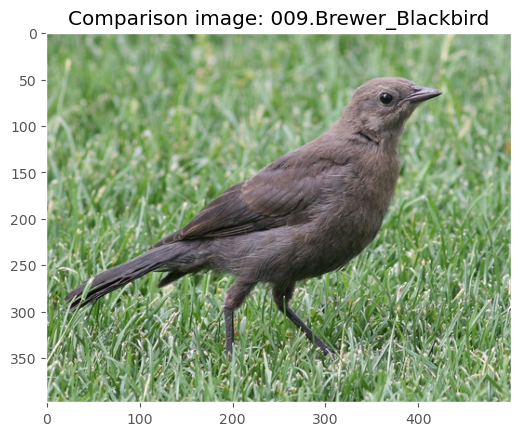

In [57]:
plot_closest_images(train_logits,valid_logits[example_idx],example_idx,dataset,'euclidean')

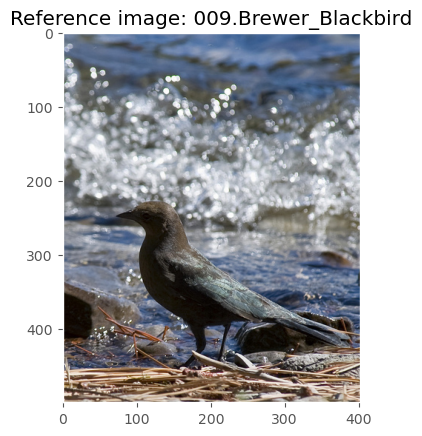

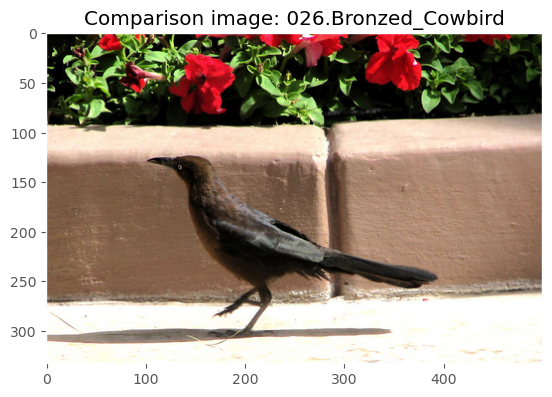

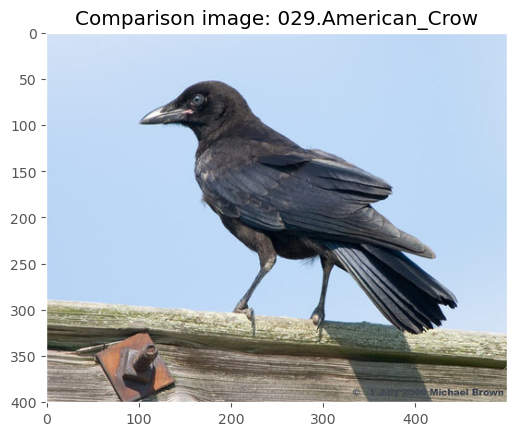

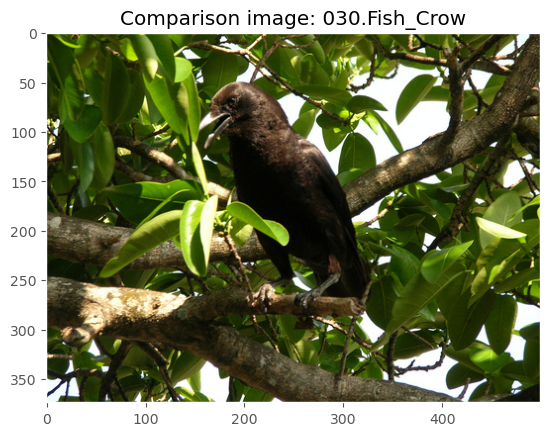

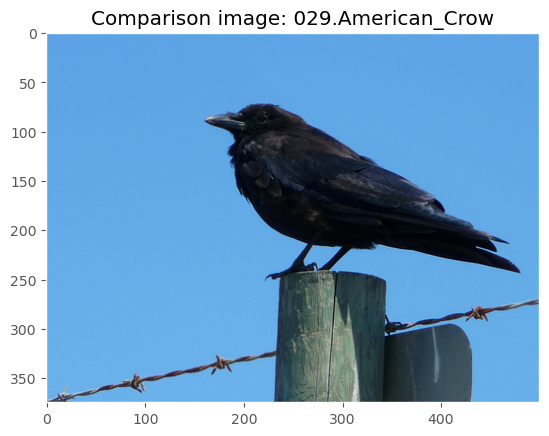

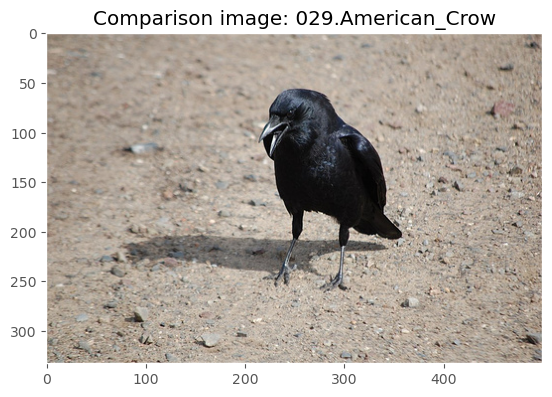

In [58]:
plot_closest_images(train_logits,valid_logits[example_idx],example_idx,dataset,lambda x,y: dist(x,y,indices_shapley))

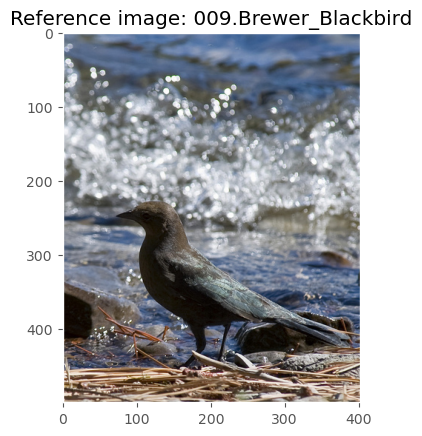

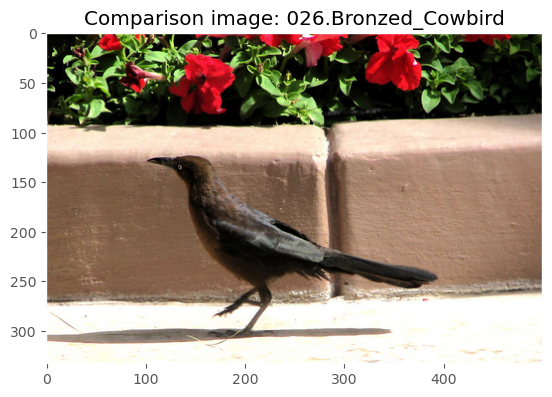

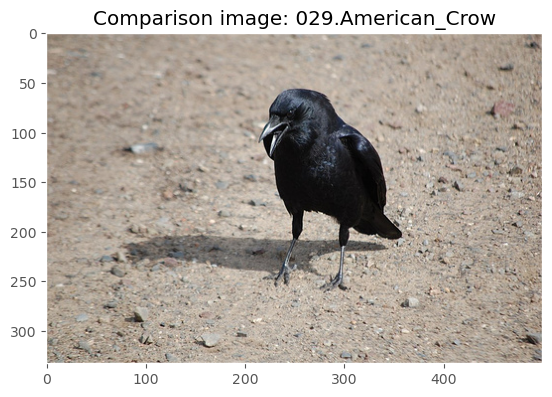

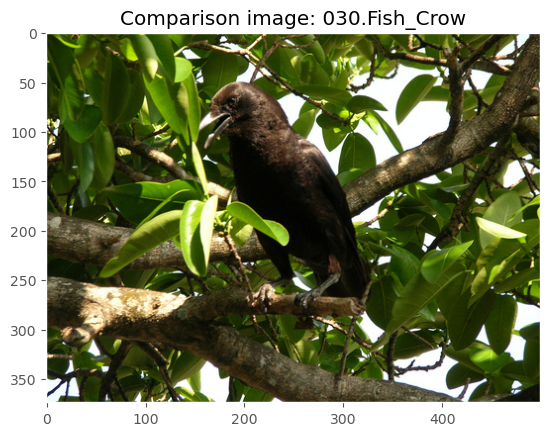

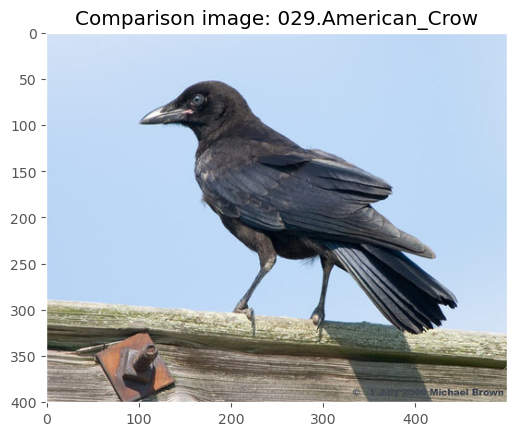

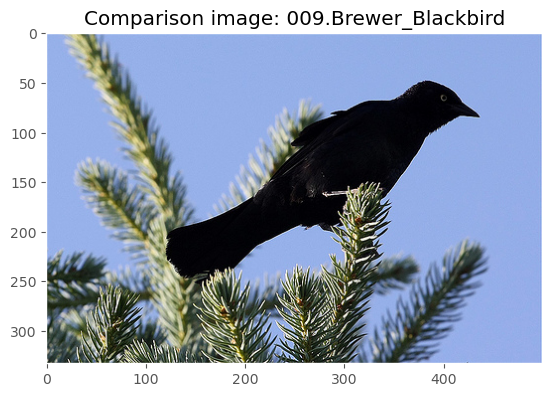

In [59]:
plot_closest_images(train_logits,valid_logits[example_idx],example_idx,dataset,lambda x,y: dist(x,y,indices_label))

In [101]:
knn = KNeighborsClassifier(n_neighbors=5,metric=lambda x,y: dist(x,y,indices_shapley))
knn.fit(train_logits, train_y)

KNeighborsClassifier(metric=<function <lambda> at 0x7fcd2d05c320>)

In [102]:
import time
start = time.time()
knn.predict(valid_logits[:10])
print(time.time()-start)

1.3805038928985596


In [103]:
sum(knn.predict(valid_logits) == valid_y)/len(valid_y)

0.8906510851419032

In [104]:
knn = KNeighborsClassifier(n_neighbors=5,metric=lambda x,y: dist(x,y,indices_label))
knn.fit(train_logits, train_y)

KNeighborsClassifier(metric=<function <lambda> at 0x7fcd2d05c560>)

In [105]:
sum(knn.predict(valid_logits) == valid_y)/len(valid_y)

0.9081803005008348

In [108]:
pickle.dump(shapley_hierarchy,open("results/hierarchies/shapley.pkl","wb"))

In [109]:
pickle.dump(label_hierarchy,open("results/hierarchies/label.pkl","wb"))